In [1]:

import uproot
import numpy as np
from matplotlib import pyplot as plt
from os import path
plt.rcParams['figure.dpi'] = 300
plt.rcParams.update({"axes.grid" : True, "grid.color": "whitesmoke"})
plt.rcParams['axes.axisbelow'] = True

In [2]:
#Open ROOT file
#file_path = "/Users/bertabeltran/MIST/data/Interposer_test/ag_Interposer_coinc_start_test_AM/RAW/SDataR_ag_coinc_start_test_AM.root"
#file_path = "/Users/bertabeltran/MIST/data/Interposer_test/interposer_64ns_timewindow/RAW/SDataR_interposer_64ns_timewindow.root"
#file_path = "/Users/bertabeltran/MIST/data/Interposer_test/interposer_64ns_timewindow_2scint/RAW/SDataR_interposer_64ns_timewindow_2scint.root"
file_path = "/Users/bertabeltran/MIST/data/Interposer_test/interposer_64ns_4pile_timewindow_long/RAW/SDataR_interposer_64ns_timewindow_long.root"
file=uproot.open(file_path)
tree=file["Data_R"]
print(tree.keys())

#Load data for channels and timestamps
#timestamps = tree["Timestamp"].array(library = "np")*10**(-3) #Convert picoseconds to nano
timestamps = tree["Timestamp"].array(library = "np") # picoseconds
channel = tree["Channel"].array(library = "np")
energy = tree["Energy"].array(library = "np")
flags = tree["Flags"].array(library = "np")

['Channel', 'Timestamp', 'Board', 'Energy', 'EnergyShort', 'Flags']


In [3]:
timestamps 

array([     164499388749,      164499388898,      164499389206, ...,
       66957136020068881, 66957209054652230, 66957290379146124],
      dtype=uint64)

In [4]:
#Create masks for channels
CH0_mask = channel == 0
CH1_mask = channel == 1
CH2_mask = channel == 2
CH3_mask = channel == 3

#Get timestamps for each channel (time in picoseconds from the begining of the run)
CH0_timestamps = timestamps[CH0_mask]
CH1_timestamps = timestamps[CH1_mask]
CH2_timestamps = timestamps[CH2_mask]
CH3_timestamps = timestamps[CH3_mask]

#Calculate energy of events on each channel
CH0_energy = energy[CH0_mask]
CH1_energy = energy[CH1_mask]
CH2_energy = energy[CH2_mask]
CH3_energy = energy[CH3_mask]

# calculate the time difference between coincidences events by looking at the time differences in ch0 for exmaple 
CH0_time_diff = np.diff(CH0_timestamps)

In [5]:
len(CH0_timestamps)

242478

In [6]:
len(CH1_timestamps)

250635

In [7]:
len(CH2_timestamps)

250635

In [8]:
len(CH3_timestamps)

250635

In [9]:
CH0_timestamps

array([     164499389643,      180126331663,      861834236514, ...,
       66957136020068881, 66957209054652230, 66957290379146124],
      dtype=uint64)

In [10]:
# need to recast the type of these arrays to a dtype which supports negative integers so that I cna subtract them 
CH0_timestamps = CH0_timestamps.astype(np.int64)
CH1_timestamps = CH1_timestamps.astype(np.int64)
CH2_timestamps = CH2_timestamps.astype(np.int64)
CH3_timestamps = CH3_timestamps.astype(np.int64)

CH0_energy = CH0_energy.astype(np.int64)
CH1_energy = CH1_energy.astype(np.int64)


In [11]:
CH0_timestamps

array([     164499389643,      180126331663,      861834236514, ...,
       66957136020068881, 66957209054652230, 66957290379146124])

In [12]:
CH0_time_diff

array([ 15626942020, 681707904851, 289947538668, ..., 851220469339,
        73034583349,  81324493894], dtype=uint64)

In [13]:
# now we transform these time differences into seconds 
CH0_time_diff=CH0_time_diff/1e+12
CH0_time_diff

array([0.01562694, 0.6817079 , 0.28994754, ..., 0.85122047, 0.07303458,
       0.08132449])

In [14]:
len(CH0_timestamps)

242478

In [15]:
len(CH0_energy)

242478

In [16]:
len(CH1_timestamps)

250635

In [17]:
len(CH2_timestamps)

250635

In [18]:
len(CH3_timestamps)

250635

In [19]:
#Ch0ch1_time_diff = CH0_timestamps_update-CH1_timestamps
#Ch0ch2_time_diff = CH0_timestamps-CH2_timestamps
#Ch0ch3_time_diff = CH0_timestamps-CH3_timestamps
Ch1ch2_time_diff = CH1_timestamps-CH2_timestamps


In [20]:
len(Ch1ch2_time_diff)

250635

In [21]:
Ch1ch2_time_diff

array([ -149,   899, -1777, ..., -1922,  -216, -5575])

In [22]:
# we want the time diffrences in ns, not in pico seconds 
#Ch0ch1_time_diff=Ch0ch1_time_diff/1000
Ch1ch2_time_diff=Ch1ch2_time_diff/1000
#Ch0ch3_time_diff=Ch0ch3_time_diff/1000

In [23]:
Ch1ch2_time_diff

array([-0.149,  0.899, -1.777, ..., -1.922, -0.216, -5.575])

Text(0.5, 1.0, ' $\\Delta$t between ch1, ch2 (pile of 4) with the interposer')

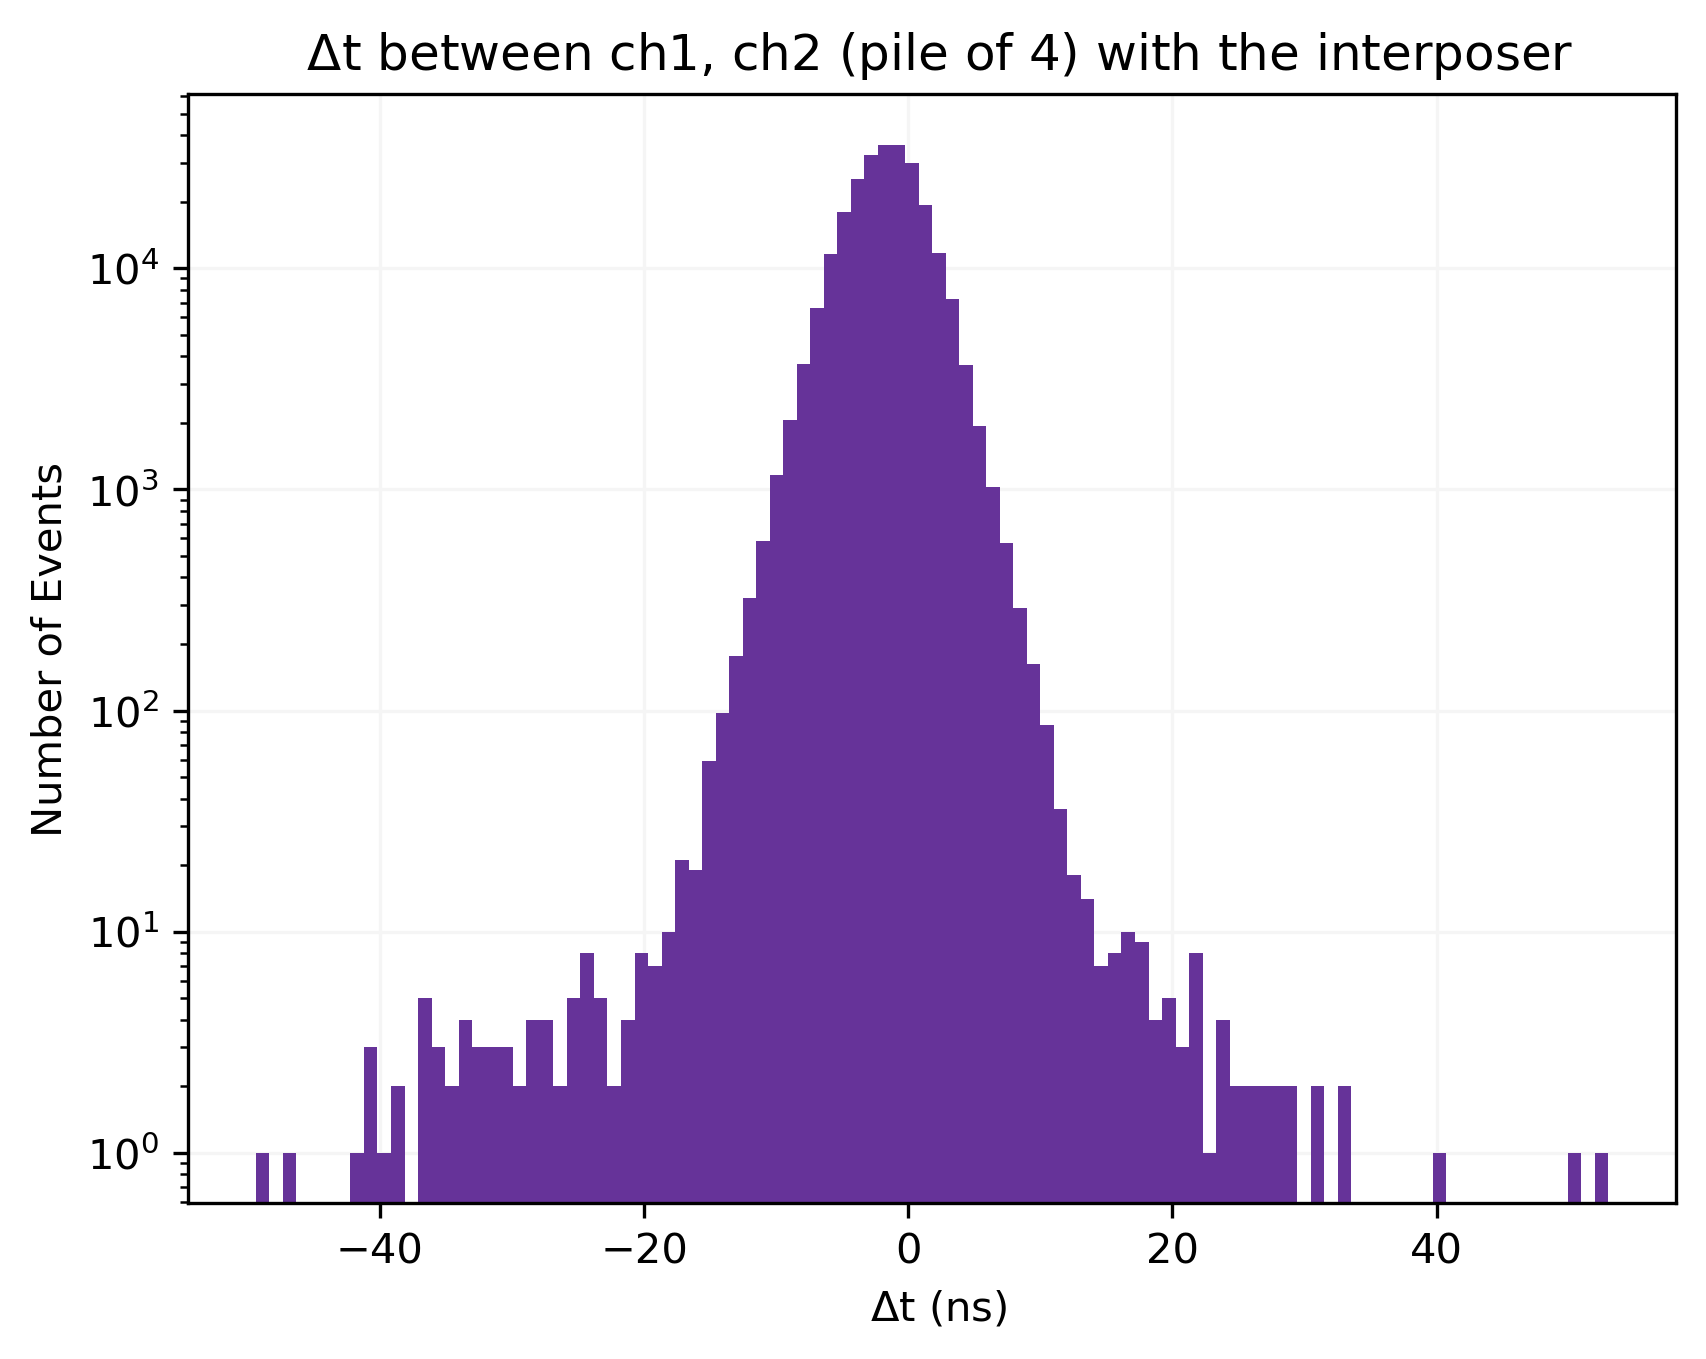

In [28]:
plt.hist(Ch1ch2_time_diff,bins =100, color='rebeccapurple')
plt.yscale('log')
x_label = " $\Delta$t (ns)"
y_label = 'Number of Events'
ax=plt.gca()
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.set_title(" $\Delta$t between ch1, ch2 (pile of 4) with the interposer")



Gaus function coefficients:
[ 3.63598202e+04 -1.62420228e+00  2.74989387e+00]
Covariance of coefficients:
[[ 1.57480680e+05 -4.80320688e-08 -7.94025437e+00]
 [-4.80320688e-08  1.20105474e-03 -2.94179579e-12]
 [-7.94025437e+00 -2.94179579e-12  1.20105476e-03]]
mean err 0.03465623671301733


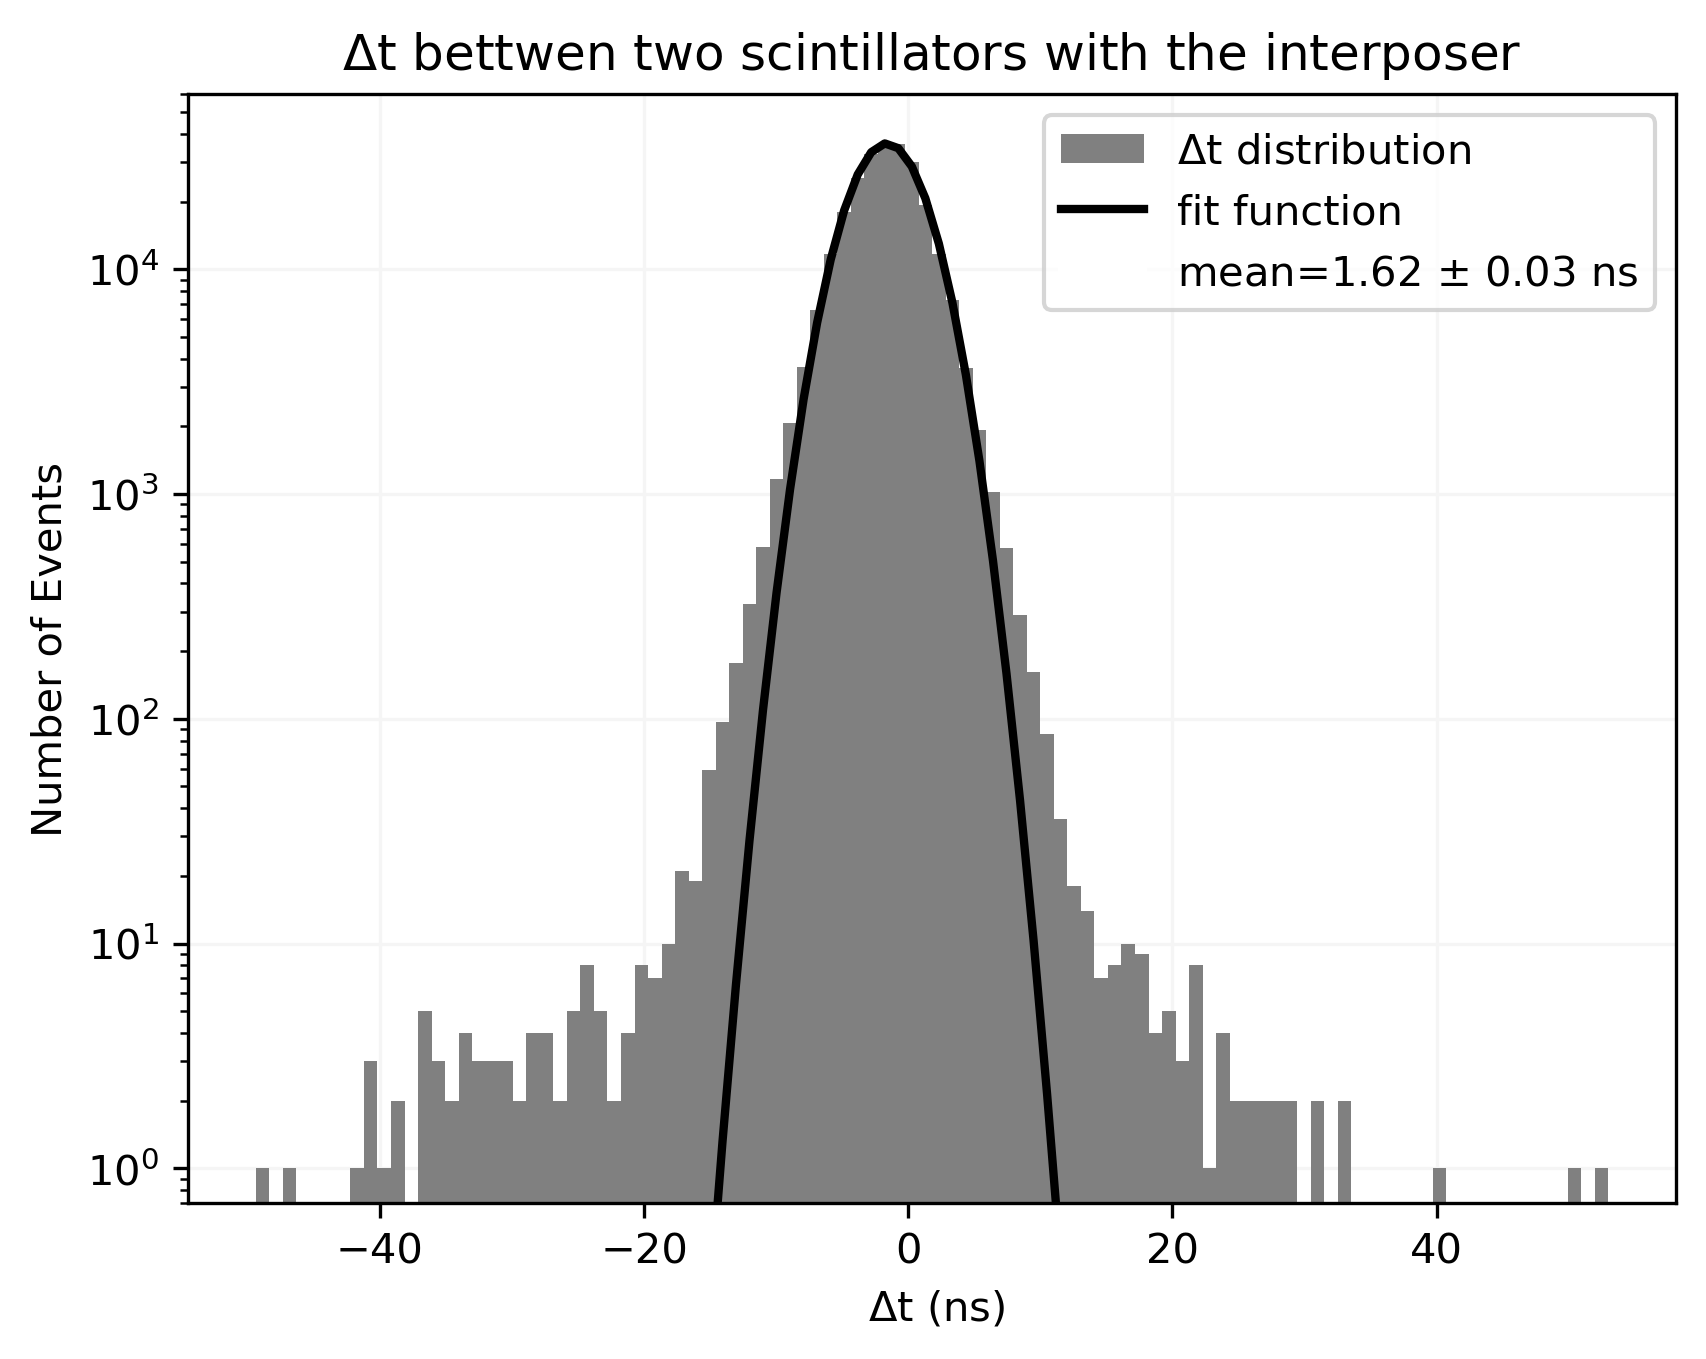

In [27]:
# becuase the plot is not centered around 0, I want to find the center and translate the plot byt the amount. 
#This way it will be centered around zero and I will be able to caclaute the intervals 
#now I am going to try and fit the time differences plot with curve_fit
import numpy as np
from scipy.optimize import curve_fit
#firts I define the fucntion that I will be fitting
#def expo(x, a, b):
#return  np.exp(a+(b*x))

def gaus(x, a, b, c):
    return  a*np.exp(-0.5*((x-b)/c)**2)

#here I caculate the bin centers for the fit
def bincenters(bins):
    return (bins[1:] + bins[:-1]) / 2
#define the histogram that I will be fitting to and return the bin contents and the bid edeges
bin_cont, bin_edges, patches = plt.hist(Ch1ch2_time_diff, bins = 100, histtype='stepfilled' , color ='gray',label ="$\Delta$t distribution")
#here I do the fit a return the fit values
centers = bincenters(bin_edges)
# I want to select only a section of the histogram entries to fit 
#select  = np.logical_and(centers > -10, centers < 20)
select= bin_cont>10
param, param_cov = curve_fit(gaus, bincenters(bin_edges)[select],bin_cont[select])
#print the values
print("Gaus function coefficients:")
print(param)
print("Covariance of coefficients:")
print(param_cov)
perr = np.sqrt(np.diag(param_cov))
print ("mean err", perr[1])
#now I also want to draw the fitted function on top of the histogram
fit_func= gaus(bincenters(bin_edges),param[0] ,param[1],param[2])
plt.plot(bincenters(bin_edges)[select], fit_func[select], 'black', linewidth=2, label ="fit function ")

#fit_eq= r"exp$({:.2f} {:.2f}x)$".format(param3[0] ,param3[1])

ax=plt.gca()
#ax.text(1, 800, fit_eq, fontsize=15)
#ax.text(2, 100, "rate={:.2f} cps".format(abs(param[1])), fontsize=15)
#ax.text(1.3, 300, "rate={:.2f} $\pm$ {:.2f} cps".format(abs(param3[1]), perr3[1]), fontsize=15)
ax.plot([],[],label="mean={:.2f} $\pm$ {:.2f} ns".format(abs(param[1]), perr[1]), color='w')
ax.set_ylim(7e-1,6e4)
plt.legend()
plt.yscale('log')
ax.set_title("$\Delta$t bettwen two scintillators with the interposer")
ax.set_xlabel(" $\Delta$t (ns) ")
ax.set_ylabel('Number of Events')
plt.show()




In [29]:
Ch1ch2_time_diff_offset=Ch1ch2_time_diff+1.62

Text(0.5, 1.0, ' $\\Delta$t between two scintillators out of a pile of 4 in coincidence')

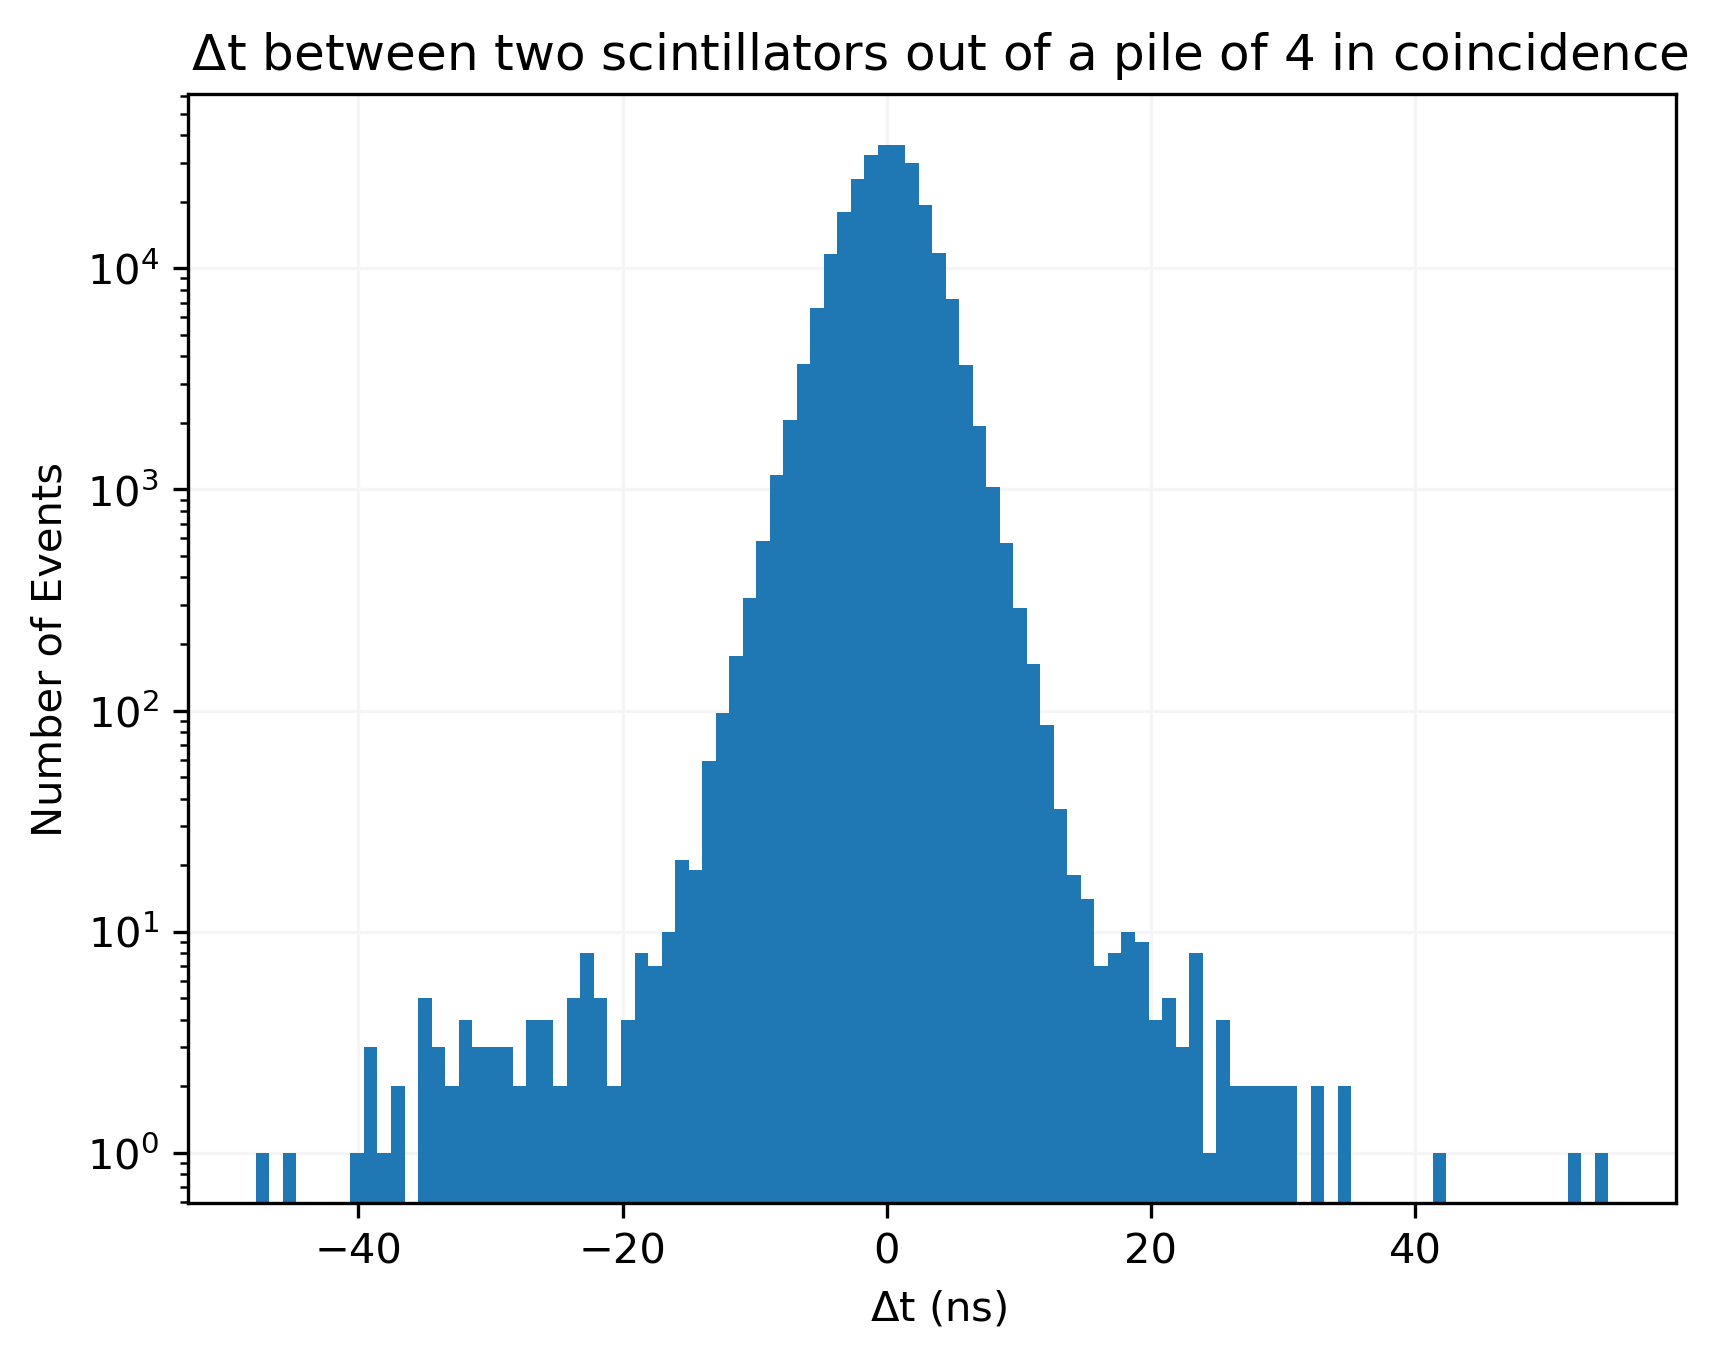

In [39]:
bin_cont, bin_edges, patches=plt.hist(Ch1ch2_time_diff_offset,bins =100)
plt.yscale('log')
x_label = " $\Delta$t (ns)"
y_label = 'Number of Events'
ax=plt.gca()
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.set_title(" $\Delta$t between two scintillators out of a pile of 4 in coincidence")



Text(0.5, 1.0, ' Percentage of area over total for different $\\Delta$t ranges ')

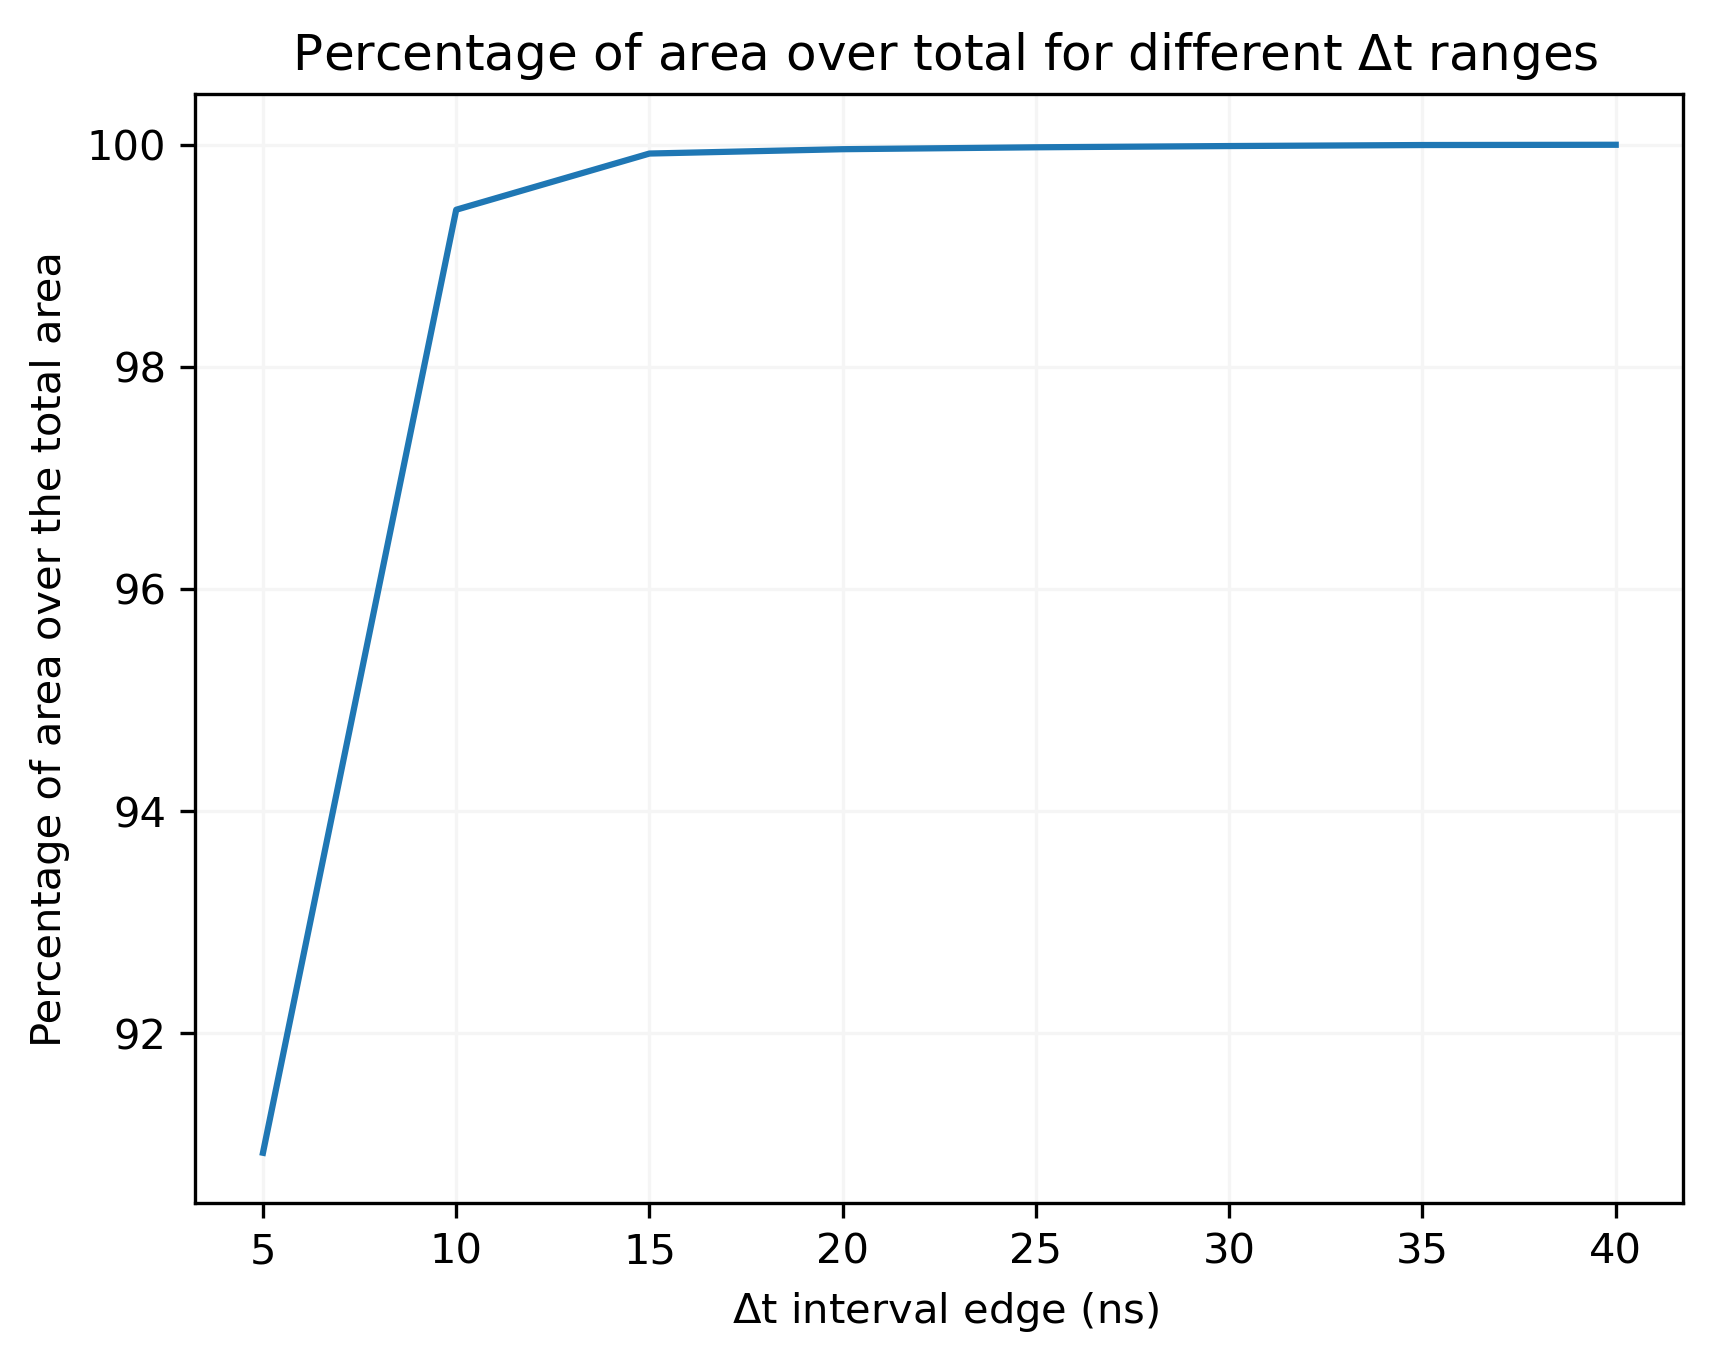

In [32]:
def bincenters(bins):
    return (bins[1:] + bins[:-1]) / 2
# now I want to calcuate the intergeal of this historgram for a given ange of delta_t
# get the width of each bin
bin_width = bin_edges[1] - bin_edges[0] # all the bins have the same width 
# now select the region that we want to integrate from 
centers = bincenters(bin_edges)

select_5  = np.logical_and(centers > -5, centers < 5)
select_10  = np.logical_and(centers > -10, centers < 10)
select_15  = np.logical_and(centers > -15, centers < 15)
select_20  = np.logical_and(centers > -20, centers < 20)
select_25  = np.logical_and(centers > -25, centers < 25)
select_30  = np.logical_and(centers > -30, centers < 30)
select_35  = np.logical_and(centers > -35, centers < 35)
select_40  = np.logical_and(centers > -40, centers < 40)
# sum over number in each bin and mult by bin width, which can be factored out
integral = bin_width * sum(bin_cont)
integral_5 = bin_width * sum(bin_cont[select_5])
integral_10 = bin_width * sum(bin_cont[select_10])
integral_15= bin_width * sum(bin_cont[select_15])
integral_20 = bin_width * sum(bin_cont[select_20])
integral_25 = bin_width * sum(bin_cont[select_25])
integral_30 = bin_width * sum(bin_cont[select_30])
integral_35 = bin_width * sum(bin_cont[select_35])
integral_40 = bin_width * sum(bin_cont[select_40])

percent_array=np.array([(integral_5*100)/integral, (integral_10*100)/integral,(integral_15*100)/integral,(integral_20*100)/integral,
                       (integral_25*100)/integral,(integral_30*100)/integral,(integral_35*100)/integral,(integral_40*100)/integral])
x_array=np.array([5,10,15,20,25,30,35,40])
plt.plot(x_array, percent_array)


x_label = " $\Delta$t interval edge (ns)"
y_label = 'Percentage of area over the total area'
ax=plt.gca()
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.set_title(" Percentage of area over total for different $\Delta$t ranges ")



In [38]:
(integral_20*100)/integral

99.95770742314522